In [ ]:
import numpy as np
from scipy.optimize import root
import matplotlib.pyplot as plt

List_methode_de_flux= ["Roe","Rusanov","Godunov"]
List_condition_limite=["Neumann","Dirichlet","Periodique"]

In [ ]:
class Finite_Volume:


    def __init__(self,u0,function, derivee_de_la_function, flux_methode, film_bool =False, condition_limite = "Neumann"):
        Valid_init = True
        self.function = function; self.derivee_de_la_function = derivee_de_la_function

        in_list =False
        for methode in List_methode_de_flux:
            if(flux_methode ==methode):  in_list =True
        if(not in_list): Valid_init = False

        in_list =False
        for condition in List_condition_limite:
            if(condition_limite ==condition): in_list =True
        if(not in_list): Valid_init = False
        

        self.flux_methode = flux_methode;   self.condition_limite = condition_limite
        self.u0=u0
        self.film_bool = film_bool
        if(not Valid_init): f"Methode non reconnue"
    
    def sol(self, J,T,  CFL=0.95):
        dx = 1./J
        X = np.linspace(0,1,J) +dx
        f = self.function; f_p = self.derivee_de_la_function
        U = self.u0(X)
        
        g = lambda u,v: 0*u + 0*v   
        for methode in List_methode_de_flux: 
            if(methode == "Godunov"): 
                g= lambda u,v : min(f(u),f(v))* (u<v) + max(f(u),f(v))*(u>=v)
            if(methode == "Rusanov"):
                g= lambda u,v : 0.5*(f(u)+f(v))-0.5*max(np.abs(f_p(u)), np.abs(f_p(v)))*(u-v)
            if(methode == "Roe"):
                g= lambda u,v : 0.5*(f(u)+f(v))-0.5*f_p(u)*(u-v)*(u!=v) + f(u)*(u==v)

        FG = np.empty_like(X) 
        FD = np.empty_like(X)

        Film=[]; F=[[],[]]  

        t=0.; n =0; dt=0.
        while t<T and n<10000:
            #calcul de dt
            vitesse = max(abs(f_p(U)))
            if(vitesse !=0) : dt = (min(CFL * dx /(2* vitesse), T-t))
            else :            dt = CFL*dx  

            if(dt<0): dt = 10e-5

            ## Calcul du flux
            for j in range(len(X)):
                
                if(j==0):   FG[j]= g(U[j],U[j+1])
                else :      FG[j]= g(U[j-1],U[j])
                
                if(j==J-1): FD[j]= g(U[j-1],U[j])
                else :      FD[j]= g(U[j],U[j+1]) 

                
            ## eval
            if(n%(J/5)==0):
                print(sum(U)/J)
                print(dt)
                print('----------',t,'------------')
               
            ## Calcul de la solution
            for j in range(len(X)):
                U[j] = U[j] -(dt/dx)* (FD[j]-FG[j])

            if(self.film_bool): Film.append(U.copy()); F[0].append(FD.copy()); F[1].append(FG.copy())
            n+=1; t+= dt
            
        
        if(self.film_bool): 
            U_xt = np.zeros((len(Film),len(U)))
            for i in range(len(Film)) : U_xt[i,:] = Film[-i]
            return U_xt
        else:               return U

In [33]:
Riemann_init = lambda U_right,U_left,x : U_left*(x<0.5) + U_right*(x>=0.5)
    

0.004
3.958333333333333e-05
---------- 0.0 ------------
-0.395
3.958333333333333e-05
---------- 0.007916666666666666 ------------
-0.795
3.958333333333333e-05
---------- 0.01583333333333349 ------------
-0.996
3.958333333333333e-05
---------- 0.02374999999999998 ------------
-0.996
3.958333333333333e-05
---------- 0.0316666666666665 ------------
-0.996
3.958333333333333e-05
---------- 0.039583333333333685 ------------
-0.996
3.958333333333333e-05
---------- 0.04750000000000087 ------------
-0.996
3.958333333333333e-05
---------- 0.05541666666666805 ------------
-0.996
3.958333333333333e-05
---------- 0.06333333333333509 ------------
-0.996
3.958333333333333e-05
---------- 0.07125000000000088 ------------
-0.996
3.958333333333333e-05
---------- 0.07916666666666668 ------------
-0.996
3.958333333333333e-05
---------- 0.08708333333333247 ------------
-0.996
3.958333333333333e-05
---------- 0.09499999999999827 ------------
-0.996
3.958333333333333e-05
---------- 0.10291666666666406 -------

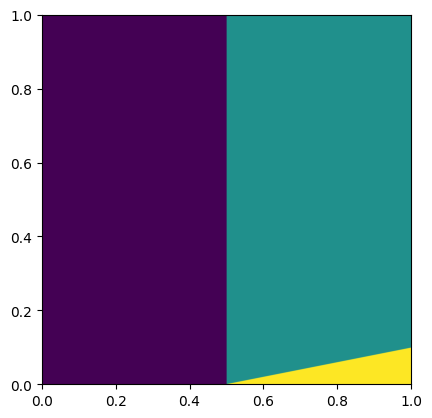

In [36]:
U0  = lambda x: Riemann_init(U_right=2, U_left=-2,x=x)
f   = lambda u: u*u*u; f_p = lambda u: 3*u*u + u*0

Fv = Finite_Volume(U0,function=f,derivee_de_la_function=f_p,flux_methode="Godunov",film_bool=True)

J=1000; T=0.2
U = Fv.sol(J= J,T= T)

fig, ax = plt.subplots()
ax.imshow(U, extent=((0,1,0,1)) )
plt.show()